In [2]:
from __future__ import print_function, division

In [3]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

Numeric simulation
------------------

Let's start with a very simple numeric simulation of a proportional controller acting on a first order process $G = \frac{y}{u} = \frac{K}{\tau s + 1}$. We know this corresponds with a differential equation $\frac{dy}{dt} = \frac{1}{\tau}(Ku - y)$

In [4]:
K = 3
tau = 2

In [5]:
Kc = 2

In [6]:
ts = numpy.linspace(0, 5, 1000)
dt = ts[1]

In [7]:
y_continuous = []
u_continuous = []
y = 0
sp = 1
for t in ts:
    e = sp - y
    u = Kc*e
    dydt = 1/tau*(K*u - y)
    
    y += dydt*dt
    
    u_continuous.append(u)
    y_continuous.append(y)

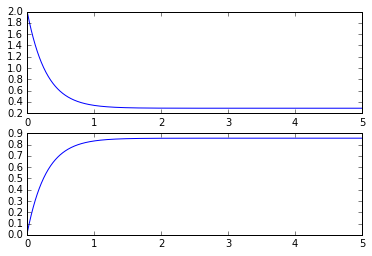

In [8]:
plt.subplot(2, 1, 1)
plt.plot(ts, u_continuous)
plt.subplot(2, 1, 2)
plt.plot(ts, y_continuous)

Now, let's use a discrete version of the same controller. We will assume a Zero Order Hold between the controller and the system.

In [9]:
DeltaT = 0.5  # sampling time

In [10]:
u_discrete = []
y_discrete = []
y = 0
sp = 1
next_sample = 0
for t in ts:
    if t >= next_sample:
        e = sp - y
        u = Kc*e
        next_sample += DeltaT
    dydt = 1/tau*(K*u - y)
    y += dydt*dt
    
    u_discrete.append(u)
    y_discrete.append(y)

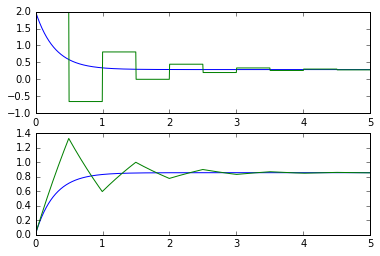

In [11]:
plt.subplot(2, 1, 1)
plt.plot(ts, u_continuous,
         ts, u_discrete)
plt.subplot(2, 1, 2)
plt.plot(ts, y_continuous,
         ts, y_discrete)

Notice the difference? Because the discrete controller only calculates its values at the sampling points and because the ZOH keeps its output constant, the discrete controller takes more action later on, in fact introducing some oscillation where the continuous controller could use arbitrarily large gain.

Symbolic calculation
--------------------

Now we will try to replicate that last figure without doing numeric simulation.  The continuous controller is trivially done via the Laplace transform:

In [12]:
import sympy
sympy.init_printing()

In [13]:
s = sympy.Symbol('s')
t = sympy.Symbol('t', positive=True)

Gc = Kc  # controller
G = K/(tau*s + 1)  # system

G_cl = Gc*G/(1 + Gc*G)

rs = 1/s  # step input r(s)

ys = rs*G_cl  # system output y(s)
es = rs - ys  # error
us = Gc*es  # controller output

yt = sympy.inverse_laplace_transform(ys, s, t)
ut = sympy.inverse_laplace_transform(us, s, t)

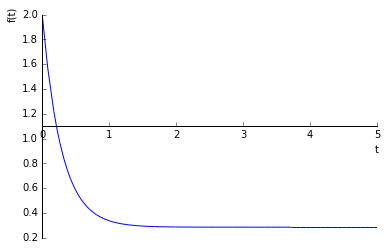

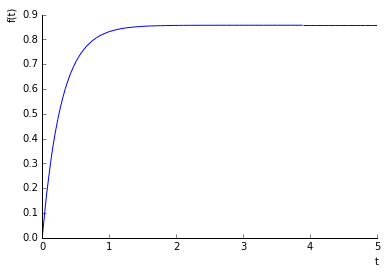

In [14]:
sympy.plot(ut, (t, 0, 5))
sympy.plot(yt, (t, 0, 5))

Now for the discrete controller. First we need some new symbols.

In [15]:
z, q = sympy.symbols('z, q')

We get the z transform of a sampled step from the table in the datasheet.

In [16]:
rz = 1/(1 - z**-1)

If we rewrite a z-transformed signal as a polynomial ($r(z) = a_0 + a_1 z^{-1} + a_2 z^{-2} \dots$ , the coefficients give the values at the sampling points, so $a_0 = r(0)$, $a_1 = r(\Delta t)$, $a_2 = r(2\Delta t)$ and so on. We can obtain these coefficients easily using a Taylor expansion in sympy.

In [17]:
rz.subs(z, q**-1).series()

We can see clearly that all the coefficients are 1 for the step. Let's define a function for these coefficients.

In [18]:
def sampledvalues(fz, N):
    return list(reversed(sympy.poly(fz.subs(z, q**-1).series(q, 0, N).removeO(), q).all_coeffs()))

In [19]:
def plotdiscrete(fz, N):
    values = sampledvalues(fz, N)
    times = [n*DeltaT for n in range(N)]
    plt.stem(times, values)

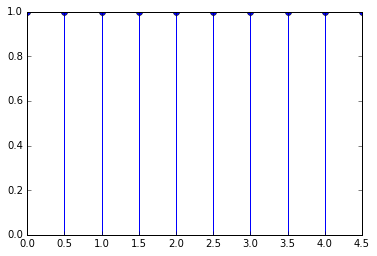

In [20]:
plotdiscrete(rz, 10)

Let's move on to the other transfer functions. The controller is simple:

In [21]:
Gcz = Kc

The controller is connected to a hold element ($H$) which is connected to the system itself ($G$). The z-transform of this combination can be written $\mathcal{Z}\{H(s)G(s)\}$. Now, $H(s) = \frac{1}{s}(1 - e^{-\Delta t s})$ and $G(s) = \frac{K}{\tau s + 1}$ so the z transform we're looking for will be $F(z) - z^{-1}F(z)$ with $F(z)$ being the transform on the right of the table of $\frac{1}{s}G(s)$.

In [32]:
a = 1/tau
b = sympy.exp(-a*DeltaT)
Fz = K*(1 - b)*z**-1/((1 - z**-1)*(1 - b*z**-1))  # In the datasheet table, this corresponds with (1 - e^{-at})
HGz = Fz - z**-1*Fz

Let's verify that this is correct by plotting the continuous response along with the discrete values:

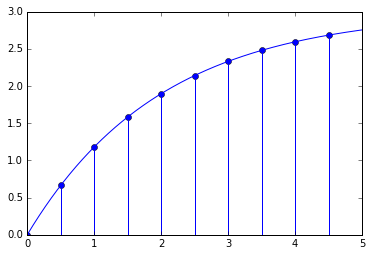

In [33]:
plotdiscrete(rz*HGz, 10)
plt.plot(ts, K*(1 - numpy.exp(-ts/tau)))

Now we have the discrete transfer functions, we can repeat the same calculation as before.

In [34]:
yz = rz*Gcz*HGz/(1 + Gcz*HGz)

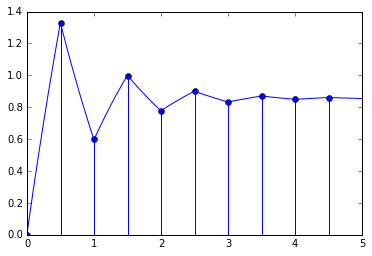

In [35]:
plotdiscrete(yz, 10)
plt.plot(ts, y_discrete)

So now we have recovered the response we calculated numerically before analytically. Let's see if we can reproduce the numeric values between the sampling points for the continuous system output. Our first step is to construct the Laplace transform of the controller output. Let's look again what that looked like:

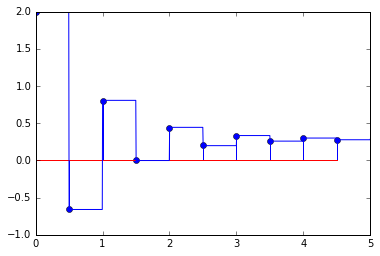

In [39]:
spz = 1/(1 - z**-1)
ez = spz - yz
uz = Gcz*ez
plotdiscrete(uz, 10)
plt.plot(ts, u_discrete)

These are clearly lots of step signals added together. Given the coefficients of $u(z)$ we can construct the Laplace transform of the held signal as follows:

In [70]:
us = sum(v/s*(1 - sympy.exp(-DeltaT*s))*sympy.exp(-DeltaT*s*i) for i, v in enumerate(sampledvalues(uz, 10)))

Now we can construct the continuous response like this:

In [74]:
ys = us*G

In [75]:
yt = sympy.inverse_laplace_transform(ys, s, t)

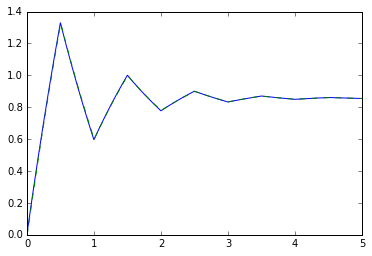

In [78]:
plt.plot(ts, y_discrete)
plt.plot(ts, [sympy.N(yt.subs(t, ti)) for ti in ts], '--')

Notice that the analytical solution and numeric solution agree, but make sure you understand what the difference is in approach.